Spx is on a low volatility streak, taking a look at how long the streaks usually last and how the current streak relates to past instances. Also looking at Spx returns once the spell breaks - as do probably most others, i expected volatility to pick up, that does not seem to be the case. Bill Luby of Vix And More had a recent post supporting the case for low volatility feeding low volatility on a more long term basis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline
plt.style.use("seaborn-whitegrid")
plt.rcParams.update({"figure.figsize":(16, 9), "grid.alpha":0.21})

# Spx since 1950’s
# https://finance.yahoo.com/quote/^GSPC/history?period1=-630986400&period2=1516572000&interval=1d&filter=history&frequency=1d
spx = pd.read_csv("../Data/^GSPC.csv", index_col="Date")
spx.index = pd.to_datetime(spx.index, format="%Y-%m-%d")
spx["pct"] = spx["Close"].pct_change()
#spx = spx[["Close", "pct"]]
spx.dropna(inplace=True)

vol_threshold = 0.01

In [2]:
spx.tail()

,Open,High,Low,Close,Adj Close,Volume,pct
Date,,,,,,,
2018-02-05,2741.060059,2763.389893,2638.169922,2648.939941,2648.939941,5283460000,-0.040979
2018-02-06,2614.780029,2701.040039,2593.070068,2695.139893,2695.139893,5891660000,0.017441
2018-02-07,2690.949951,2727.669922,2681.330078,2681.659912,2681.659912,4626570000,-0.005002
2018-02-08,2685.010010,2685.270020,2580.560059,2581.000000,2581.000000,5305440000,-0.037536
2018-02-09,2601.780029,2638.669922,2532.689941,2619.550049,2619.550049,5680070000,0.014936


Looking at the last instance where Spx had a daily move of +/-1% or greater

In [3]:
latest_instance = spx[abs(spx["pct"]) >= vol_threshold].iloc[-1]
latest_instance.name

Timestamp('2018-02-09 00:00:00')

Lets look at the previous low volatility streaks. Setting up the streak instances count and index

In [4]:
spx_reset = spx.copy().reset_index()
instances = pd.DataFrame(index=spx_reset.index)

start_index = None
for index, row in spx_reset.iterrows():
    abs_ret = abs(row["pct"])
    abs_ret_yest = abs(spx_reset["pct"].iloc[index-1])

    if abs_ret <= vol_threshold and abs_ret_yest > vol_threshold:
        start_index = index-1
        
    if abs_ret > vol_threshold and abs_ret_yest <= vol_threshold:
        rets = spx_reset["pct"].loc[start_index:index]
        rets.iloc[:1] = 0
        instances[index] = rets.reset_index(drop=True)
        start_index = None

instances.dropna(inplace=True, how="all")

Setting up current instance and plotting everything, meaning all low vol instances longer than 21 days. No signal here, just interesting to see where the current low vol streak is in relation to past streaks

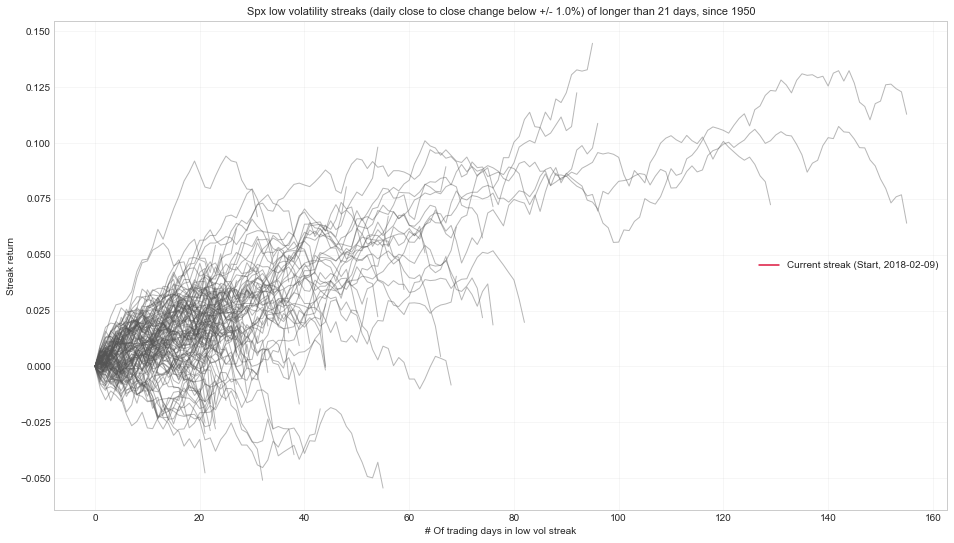

In [5]:
curr_instance = spx["pct"].loc[latest_instance.name:].reset_index(drop=True)
curr_instance[:1] = 0

for index, col in instances.iteritems():
    rets = col.dropna()
    if len(rets) > 21:
        plt.plot(rets.cumsum(), color="#555555", alpha=0.42, linewidth=1, label="_nolegend_")
        
plt.plot(curr_instance.cumsum(), color="crimson", label="Current streak (Start, {})".format(str(latest_instance.name)[:10]))
plt.title("Spx low volatility streaks (daily close to close change below +/- {}%) of longer than 21 days, since 1950".format(vol_threshold*100), fontsize=11)
plt.xlabel("# Of trading days in low vol streak")
plt.ylabel("Streak return")
plt.legend(loc="center right")

Now that the streaks are defined, one can look at the corresponding Spx 3 month forward returns when the spell breaks and Spx gets a move of more that 1% to up or down. I included only performance fo streaks longer than 21 days. I was expecting to see volatility pick up

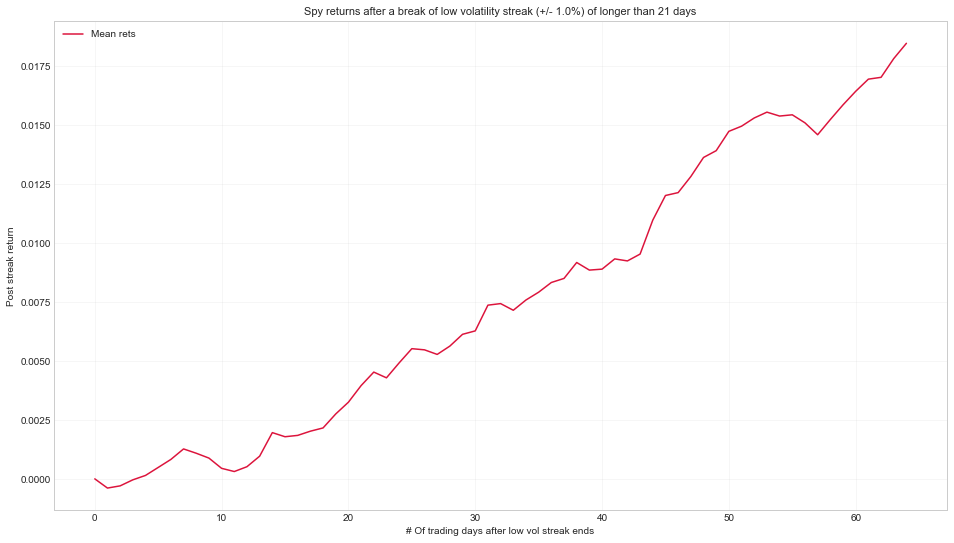

In [7]:
all_rets = pd.DataFrame()

for i in instances.columns:
    if len(instances[i].dropna()) >= 21:
        start_index = i
        rets = spx_reset["pct"].iloc[start_index:start_index+65].reset_index(drop=True)
        rets.iloc[:1] = 0
        #print(rets)
        plt.plot(rets.cumsum(), color="#555555", alpha=0.42, linewidth=1, label="_nolegend_")
        all_rets[i] = rets
        
plt.plot(all_rets.mean(axis=1).cumsum(), color="crimson", label="Mean rets")
plt.title("Spy returns after a break of low volatility streak (+/- {}%) of longer than 21 days".format(vol_threshold*100), fontsize=11)
#plt.yticks(np.arange(-0.16, 0.11, 0.02))
#plt.xlim(0, 63)
plt.xlabel("# Of trading days after low vol streak ends")
plt.ylabel("Post streak return")
plt.legend(loc="upper left")
plt.grid(alpha=0.21)

Thanks your time